<img src='https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png' width=250px>

This notebook is a compliment to the *Hyperparameter Optimization on Keras* article. 

## Overview

There are four steps to setting up an experiment with Talos:

1) Imports and data

2) Creating the Keras model

3) Defining the Parameter Space Boundaries 

4) Running the Experiment

## 1. The Required Inputs and Data

In [0]:
!pip install git+https://github.com/autonomio/talos

  Cloning https://github.com/autonomio/talos to /tmp/pip-req-build-4w0r5zd3
  Running command git clone -q https://github.com/autonomio/talos /tmp/pip-req-build-4w0r5zd3
  Created wheel for talos: filename=talos-0.6.4-cp36-none-any.whl size=53460 sha256=b5f5f0b6786ce42486225bf9109effae828b6fd2056576c069b835922b856e43
  Stored in directory: /tmp/pip-ephem-wheel-cache-vw9ekc_0/wheels/20/f1/9a/63a4168fd779c183fcc5a8ebe6aa34f1f9bc33eaa558e5461b
Successfully built talos


In [33]:
##!pip install talos


In [0]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

%matplotlib inline

import sys
sys.path.insert(0, './talos')
import talos
import wrangle

In [0]:
# then we load the dataset
x, y = talos.templates.datasets.breast_cancer()

# and normalize every feature to mean 0, std 1
#x = talos.utils.rescale_meanzero(x)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
x_scaled = scaler.fit_transform(x)

In [15]:
x=x_scaled
x_scaled.mean(),x_scaled.std()


(1.2487570048507913e-18, 1.0)

## 2. Creating the Keras Model

In [0]:
# first we have to make sure to input data and params into the function
def breast_cancer_model(x_train, y_train, x_val, y_val, params):
    #print("\nParams:",params)
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['acc', talos.utils.metrics.f1score])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        validation_split=0.2,
                        verbose=0)

    return history, model

## 3. Defining the Parameter Space Boundary

In [0]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[9,10,11],
     'hidden_layers':[0, 1, 2],
     'batch_size': [30],
     'epochs': [100],
     'dropout': [0],
     'kernel_initializer': ['uniform','normal'],
     'optimizer': ['Nadam', 'Adam'],
     'losses': ['binary_crossentropy'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid']}

## 4. Starting the Experiment

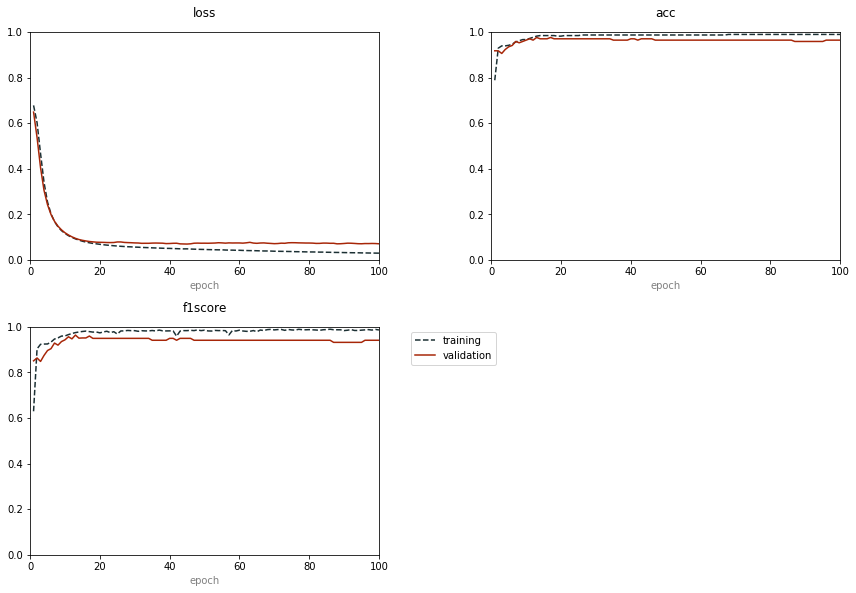

100%|██████████| 10/10 [13:19<00:00, 79.88s/it]


In [18]:
# and run the experiment
t = talos.Scan(x=x,
               y=y,
               model=breast_cancer_model,
               params=p,
               experiment_name='breast_cancer',
               round_limit=10)

Now we can assume the case where we no longer have access to the `scan_object`. In this `Scan(...experiment_name...)` was set to "reactivate" so we'll find a folder with that name in the present working directory. Next we have to find out what is the name of the experiment log.

In [34]:
# get the name of the experiment log
!ls -lhtr breast_cancer

total 4.0K
-rw-r--r-- 1 root root 2.0K Oct 26 10:12 102619095843.csv


In this case it will be the most recent one `102619095843.csv` so let's go ahead and recover the best models.

In [36]:
import talos
from talos.utils.recover_best_model import recover_best_model
results, models = recover_best_model(x_train=x,
                                     y_train=y,
                                     experiment_log='breast_cancer/102619095843.csv',
                                     input_model=breast_cancer_model,
                                     n_models=10,
                                     task='multi_label')

ModuleNotFoundError: ignored

Now we can access the cross-validation results:

In [0]:
results

We can also access the models and make predictions with them:

In [0]:
models[0].predict(x_val)